### Load Necessary Libraries

In [1]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 

# Data Splitting 
import os.path
import argparse
import random
import datetime as dt
import copy

# Data Augmentation 
import PIL
#
import cv2
import glob
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import os

ModuleNotFoundError: No module named 'cv2'

### Use Keras Model Architecture

In [2]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers, optimizers
from keras.optimizers import SGD
import tensorflow as tf

ModuleNotFoundError: No module named 'keras'

## Dataset Preparation

In [3]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [4]:
# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [5]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [6]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [7]:
image_df.head()

,id,width,height,file_name,license,flickr_url,coco_url,date_captured,flickr_640_url
0,0,1537,2049,batch_1/000006.jpg,None,https://farm66.staticflickr.com/65535/33978196...,None,None,https://farm66.staticflickr.com/65535/33978196...
1,1,1537,2049,batch_1/000008.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
2,2,1537,2049,batch_1/000010.jpg,None,https://farm66.staticflickr.com/65535/40888872...,None,None,https://farm66.staticflickr.com/65535/40888872...
3,3,2049,1537,batch_1/000019.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
4,4,1537,2049,batch_1/000026.jpg,None,https://farm66.staticflickr.com/65535/33978199...,None,None,https://farm66.staticflickr.com/65535/33978199...


In [8]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [9]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )


In [10]:
final_merged_df

,file_name,segmentation,area,bbox,iscrowd,name
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle
...,...,...,...,...,...,...
1437,batch_9/000040.jpg,"[[1283, 1596, 1365, 1828, 1384, 1880, 1402, 18...",7086.5,"[1282.8572, 1590.0, 150.95240000000013, 393.80...",0,Plastic straw
1438,batch_9/000048.jpg,"[[1816, 2448, 1514, 2239, 1438, 2177, 1286, 20...",44482.5,"[1152.0, 1732.0, 690.0, 716.0]",0,Plastic straw
1439,batch_9/000053.jpg,"[[559, 1505, 595, 1506, 609, 1500, 614, 1511, ...",635.5,"[557.0, 1500.0, 57.0, 17.999999999999773]",0,Plastic straw
1440,batch_9/000095.jpg,"[[898, 1572, 881, 1517, 891, 1521, 911, 1571]]",576.0,"[881.0, 1517.0, 30.0, 55.0]",0,Plastic straw


In [11]:
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


# First Approach without cropping images

In [12]:
train_df = final_merged_df[['filename','category']]
train_df = train_df.drop_duplicates(subset='filename')

In [13]:
train_df['category'].value_counts()

Clear plastic bottle    211
Cigarette               151
Drink can               125
Glass bottle             74
Plastic straw            67
Name: category, dtype: int64

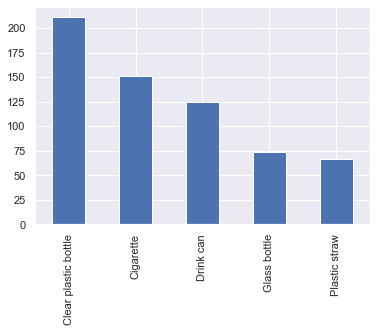

In [14]:
train_df['category'].value_counts().plot.bar()

In [15]:
# Data splitting into train and test data and keep this test data aside for model prediction
trainData_df, testData_df = train_test_split(train_df, test_size=0.20, random_state=42,stratify = train_df['category'] )
trainData_df = trainData_df.reset_index(drop=True)
testData_df = testData_df.reset_index(drop=True)

In [16]:
trainData_df['category'].value_counts()

Clear plastic bottle    169
Cigarette               121
Drink can               100
Glass bottle             59
Plastic straw            53
Name: category, dtype: int64

In [17]:
total_train = trainData_df.shape[0]
total_test = testData_df.shape[0]
batch_size=1

In [18]:
total_test

126

In [19]:
# Define Constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [20]:
# generic image data generator 
datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.25
)

In [21]:
# Train image data generator
# Create new train folder directory which should have images
train_generator=datagen.flow_from_dataframe(
    dataframe=trainData_df,
    directory="./trainDataTACO/",
    x_col="filename",
    y_col="category",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE
)


Found 377 validated image filenames belonging to 5 classes.


In [22]:
# Validation image data generator
valid_generator=datagen.flow_from_dataframe(
    dataframe=trainData_df,
    directory="./trainDataTACO/",
    x_col="filename",
    y_col="category",
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE
)

Found 125 validated image filenames belonging to 5 classes.


In [23]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testData_df,
    directory="./trainDataTACO/",
    x_col="filename",
    y_col=None,
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE
)

Found 126 validated image filenames.


In [24]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

In [25]:
#Model Summary
model.summary()

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 

In [26]:
!python --version

Python 3.7.7


In [151]:
# Compile Model
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [152]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10
412/412 [==============================] - 268s 650ms/step - loss: 1.5959 - accuracy: 0.3058 - val_loss: 28.8359 - val_accuracy: 0.0584
Epoch 2/10
412/412 [==============================] - 255s 620ms/step - loss: 1.5697 - accuracy: 0.3180 - val_loss: 71.8231 - val_accuracy: 0.0511
Epoch 3/10
412/412 [==============================] - 227s 552ms/step - loss: 1.5497 - accuracy: 0.3180 - val_loss: 8.4274 - val_accuracy: 0.0730
Epoch 4/10
412/412 [==============================] - 224s 544ms/step - loss: 1.5386 - accuracy: 0.3180 - val_loss: 157.6800 - val_accuracy: 0.1168
Epoch 5/10
412/412 [==============================] - 4447s 11s/step - loss: 1.5353 - accuracy: 0.3180 - val_loss: 52.7841 - val_accuracy: 0.1533
Epoch 6/10
412/412 [==============================] - 275s 668ms/step - loss: 1.5308 - accuracy: 0.3180 - val_loss: 74.7286 - val_accuracy: 0.1168
Epoch 7/10
412/412 [==============================] - 327s 793ms/step - loss: 1.5321 - accuracy: 0.3180 - val_loss: 75.

In [51]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
STEP_SIZE_TEST

138

In [52]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_TEST)

[100.31158447265625, 0.18115942180156708]

In [53]:
test_generator.reset()
pred=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,
verbose= 1)

138/138 [==============================] - 33s 236ms/step


In [54]:
predicted_class_indices=np.argmax(pred,axis=1)

In [55]:
labels = (train_generator.class_indices)
labels

{'Cigarette': 0,
 'Clear plastic bottle': 1,
 'Drink can': 2,
 'Paper cup': 3,
 'Unlabeled litter': 4}

In [56]:
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [57]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,"Predictions":predictions})

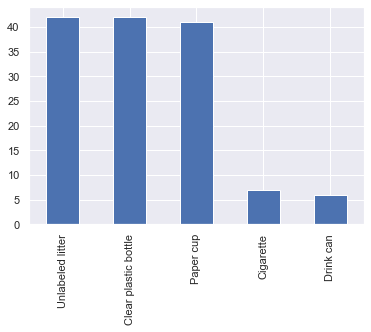

In [58]:
results['Predictions'].value_counts().plot.bar()